# WaveNet

In this notebook, I have tried to implement the Makemore: Part 5 from Andrej Karpathy's series. This notebook is my implementation, along with the notes that I took while following along the lecture.

In [147]:
# imports
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

### Building the Dataset

Same as always- we're creating training, test, and validation datasets where each training input is a three character sequence and the output is the 4th character that we want to predict.

In [148]:
# Read Data
words = open(r'../names.txt', 'r').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [149]:
# Building vocabulary and Basic Character encoding and decoding

chars = sorted(list(set(''.join(words)))) # Get all the unique chars in sorted order

stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print("itos: ", itos)
print("Vocab Size is: ", vocab_size)

itos:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab Size is:  27


In [150]:
import random

random.seed(42)
random.shuffle(words)

In [151]:
block_size = 3 

def build_dataset(words):
    X, Y = [ ], [ ]

    for w in words:
        context = [0] * block_size # For start of the word, have a padded context
        for char in w + ".":
            idx = stoi[char]
            X.append(context)
            Y.append(idx)

            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [152]:
# Train, Validation, and test split
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words=words[:n1]) # 80% of data
X_val, Y_val = build_dataset(words=words[n1:n2]) # 10% of data
X_test, Y_test = build_dataset(words=words[n2:]) # 10% of data

print("Train sizes: ", X_train.shape, Y_train.shape)
print("Validation Sizes: ", X_val.shape, Y_val.shape)
print("Test Sizes: ", X_test.shape, Y_test.shape)

Train sizes:  torch.Size([182625, 3]) torch.Size([182625])
Validation Sizes:  torch.Size([22655, 3]) torch.Size([22655])
Test Sizes:  torch.Size([22866, 3]) torch.Size([22866])


## PyTorch-ifying

In part 3, we PyTorch-ified some of our code. We defined layers and modules, but there is more simplification that we can do. We do it in this section.

This is what we had so far.

In [153]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in **0.5) # Divide by sqrt(fan_in)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps # Small number to avoid zero division error when normalization
        self.momentum = momentum
        self.training = True

        # Parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Not parameters- "buffers"
        self.running_mean = torch.ones(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, x:torch.Tensor):
        if self.training:
            xmean = x.mean(0, keepdim=True) # Batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # Batch variance

        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize to zero mean and unit variance

        self.out = self.gamma * xhat +  self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

With these modules, we were defining the layers, like this. But before going there, let's define the manual seed for PyTorch.

In [154]:
torch.manual_seed(42);

In [155]:
n_emb = 10
n_hidden = 200

C = torch.randn((vocab_size, n_emb))
layers = [
    Linear(n_emb * block_size, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), 
    Tanh(), 
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1 # Make the last layer less confident

parameters = [ C ] + [ p for layer in layers for p in layer.parameters() ]

for p in parameters:
    p.requires_grad = True

print("Total Number of Parameters: ", sum(p.nelement() for p in parameters))

Total Number of Parameters:  12097


In [156]:
epochs = 10_000
batch_size = 32
lossi = [ ]

for i in range(epochs):

    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    x_batch, y_batch = X_train[ix], Y_train[ix]

    # Observe these two lines- no PyTorch-ifying them yet
    embeddings = C[x_batch]
    x = embeddings.view(embeddings.shape[0], -1)

    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, y_batch)

    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data -= 0.01 * p.grad

    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/  10000: 3.2966
   1000/  10000: 2.8256
   2000/  10000: 2.5689
   3000/  10000: 2.3763
   4000/  10000: 2.6376
   5000/  10000: 2.3220
   6000/  10000: 2.4298
   7000/  10000: 2.1260
   8000/  10000: 2.0649
   9000/  10000: 2.7539


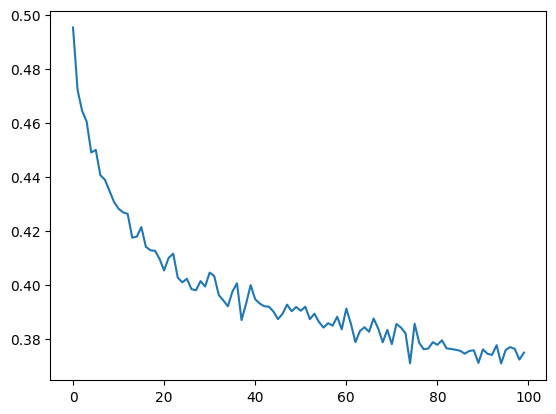

In [157]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1)); # Plot average of 100 losses

But note that the embedding matrix and the `torch.view()` operation weren't part of the layers. So we build these modules.

In [158]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x) -> None:
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

Now, we can get rid of the `C` matrix and `embeddings.view()` method, and define these two classes inside the layers list:

In [159]:
n_emb = 10
n_hidden = 200

layers = [
    Embedding(vocab_size, n_emb),
    Flatten(),
    Linear(n_emb * block_size, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), 
    Tanh(), 
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1 # Make the last layer less confident

parameters = [ p for layer in layers for p in layer.parameters() ] # No need to add 'C' in this list, bcoz it's included
for p in parameters:
    p.requires_grad = True

We can get rid of those two lines in the training loop also:

In [160]:
epochs = 10_000
batch_size = 32

for i in range(epochs):

    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    x_batch, y_batch = X_train[ix], Y_train[ix]

    x = x_batch # Added this line to pass the x_batch as input to the layers
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, y_batch)

    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data -= 0.01 * p.grad

    break
print(loss.item())

3.2878336906433105


We can do even better! Instead of defining the `layers` list and then looping over it in the loop, we can define a class that does it for us. We define container classes, such as `Sequential` or `Module`, which are also present in the PyTorch's `nn` module. Since we want to iterate over the layers sequentially, we will define the `Sequential` class.

In [162]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

Now, our model definition and training loop simplifies even more:

In [163]:
n_emb = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_emb),
    Flatten(),
    Linear(n_emb * block_size, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), 
    Tanh(), 
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # Make the last layer less confident

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True

In [164]:
epochs = 10_000
batch_size = 32
lossi = [ ]

for i in range(epochs):

    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    x_batch, y_batch = X_train[ix], Y_train[ix]

    logits = model(x_batch)
    loss = F.cross_entropy(logits, y_batch)

    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data -= 0.01 * p.grad

    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/  10000: 3.2892
   1000/  10000: 2.7455
   2000/  10000: 2.5370
   3000/  10000: 2.6041
   4000/  10000: 2.4989
   5000/  10000: 2.3094
   6000/  10000: 2.2527
   7000/  10000: 2.4661
   8000/  10000: 2.5140
   9000/  10000: 2.3215


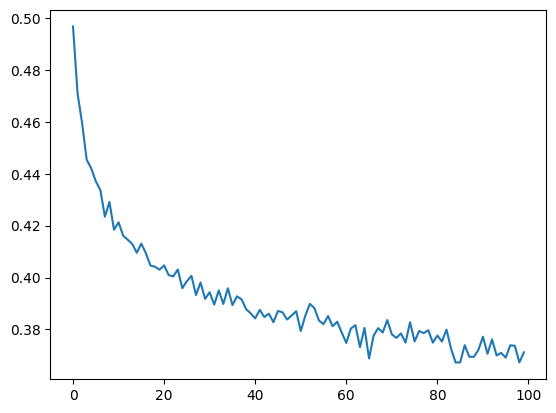

In [165]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1)); # Plot average of 100 losses

For inference, however, we need to set that each of the layers are not in training mode. Remember how the batch normalization layer has a different behavior when it is in training mode as compared to in testing mode?

In [166]:
# Set "evaluation" mode for each layer
for layer in model.layers:
    layer.training = False

In [167]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': [X_train, Y_train], 
        'test': [X_test, Y_test], 
        'val': [X_val, Y_val]
    }[split]

    logits = model(x)

    loss = F.cross_entropy(logits, y) # PyTorch will apply softmax internally

    print(f"For {split}, loss was: {loss.item()}")

split_loss('train')
split_loss('val')

For train, loss was: 2.345102071762085
For val, loss was: 2.345578193664551


Sampling from the model also simplifies:

In [168]:
for _ in range(20):
    out = [ ]
    context = [ 0 ] * block_size

    while True:
        logits = model(torch.tensor([context]))
        probabilities = F.softmax(logits, dim=1)

        ix = torch.multinomial(probabilities, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

arqyyah.
fria.
dia.
lesena.
seronng.
vhrxps.
naqdin.
mengh.
sydian.
kaleyan.
alleson.
coarasayvlilnarmandeyn.
daxee.
ajaleh.
epyn.
kem.
a.
marrich.
jahamayle.
tanhlian.


We are seeing similar training and validation losses, which is an indication that our model is not overfitting. So we can try out slightly bigger and deeper models to improve performance.

Instead of giving only three words as context, we can try to pass more words as context, and that can increase performance slightly. But the problem still remains, we're squishing too much information too fast. All the embeddings are getting squished by the Tanh in the first layer. By tweaking the context length, etc. parameters, we're getting into hyperparameter tuning too fast. So as Radek Osmulski says, instead of training a more complicated model, try out different architectures first. So we implement the WaveNet architecture as in the lecture. 

The goal is to train hierarchical model that first takes two characters and merges them in the first layer. In the second layer, it takes two more and merges them, and so on till you have one character. So if you have a context length of eight, you're going to have four "fusing" layers till you get to the last prediction layer.

### Detour: Playing With Dimensions

Currently, when we are training our network, we have a batch dimension of 4. In each training example, there are 8 characters that are 10 dimensional. So we get a dimension of $(4 \times 8 \times 10)$. Then when we pass this through the flatten layer (before the matrix multiplication), we are stacking all the embeddings of a input sample one after the other, and so we get the dimensions as: $(4 \times 80)$.

Now, we want to train a hierarchical network. Again, assume that we have a batch size of 4. To make our plots manageable, assume that the context length is 4 instead of 8.

Let's visualize the dimensions: We have a batch size of 4. In each input example, there are four characters and each character has 10 dimensional embeddings. That gives us a shape of $(4 \times 4 \times 10)$. 

In a hierarchical network, we want to "fuse" two characters together. For example, if our training example is (a, b, c, d), we want to group them as (a, b) and (c, d). 

In the plot below, all the even rows are the starting characters in our groups, and the red rows are the second character in our groups.

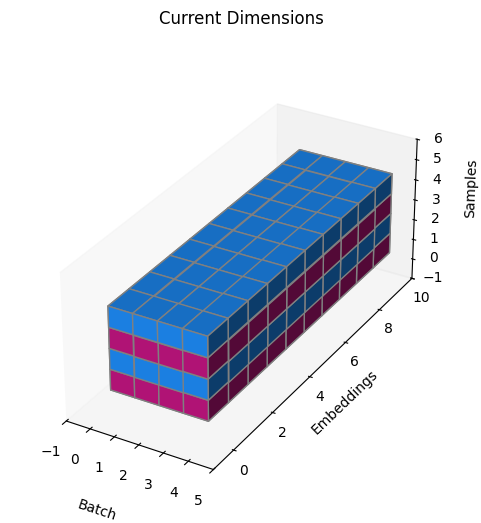

In [169]:
# hide cell
import numpy as np
import matplotlib.pyplot as plt

# Dimensions of the cube
dim1, dim2, dim3 = 4, 10, 4  # First, second, and third dimensions (x, z, y)

# Create a 3D grid for the cube
x, y, z = np.meshgrid(
    np.arange(dim1), np.arange(dim3), np.arange(dim2), indexing="ij"
)

# Initialize a boolean array for the cube
cube = np.ones((dim1, dim2, dim3), dtype=bool)

# Define colors: alternate colors along the second dimension (z-axis)
colors = np.empty(cube.shape, dtype=object)
for j in range(dim3):  # Iterate over the second dimension
    color = "#C71585" if j % 2 == 0 else "#1E90FF"
    colors[:, :, j] = color

# Plot the filled cube
fig = plt.figure(figsize=(6, 6))  # Larger figure size for better spacing
ax = fig.add_subplot(111, projection="3d")

# Use voxels to render the cube
ax.voxels(cube, facecolors=colors, edgecolor="#808080")  # Softer edge color

# Set labels
ax.set_xlabel("Batch", labelpad=10)
ax.set_ylabel("Embeddings", labelpad=10)
ax.set_zlabel("Samples", labelpad=10)

# Set the axis limits explicitly to give the cube more breathing space
ax.set_xlim(-1, dim1 + 1)
ax.set_ylim(-1, dim3 + 6)
ax.set_zlim(-1, dim2 - 4)

# Adjust aspect ratio for better proportions
ax.set_box_aspect([dim1, dim2, dim3])  # Proportional scaling

# Remove gridlines for clarity
ax.grid(False)

# Set background color to white for better contrast
ax.set_facecolor("white")

# Title
plt.title("Current Dimensions", pad=20)
plt.show()


Now, let's pluck out the odd and the even rows from this plot. 

Remember: in Python, if you want to take all the elements at even indices you can do: $L[::2]$, and if you want all the elements at odd indices, you can do: $L[1::2]$. We can do something similar in PyTorch. We want to pluck out odd and the even rows from the middle dimension while keeping the rest of the dimensions same. We can do it as this:

In [170]:
e = torch.randn(4, 4, 10) # Assume this is your batch input of size 4 X 4 X 10
e[:, ::2, :].shape # pluck out the even characters

e[:, 1::2, :].shape # Pluck out the odd characters

torch.Size([4, 2, 10])

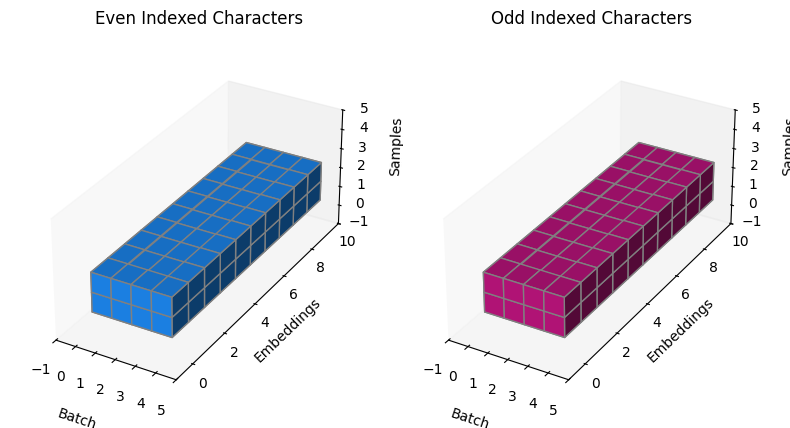

In [171]:
# hide cell
import numpy as np
import matplotlib.pyplot as plt

# Dimensions of the cubes
dim1, dim2, dim3 = 4, 10, 2  # First, second, and third dimensions (x, z, y)

# Create a 3D grid for the cubes
x, y, z = np.meshgrid(
    np.arange(dim1), np.arange(dim3), np.arange(dim2), indexing="ij"
)

# Initialize a boolean array for the cubes
cube = np.ones((dim1, dim2, dim3), dtype=bool)

# Create subplots for the two cubes
fig = plt.figure(figsize=(8, 8))  # Wider figure to accommodate two plots

# Plot the first cube (Blue)
colors1 = np.full(cube.shape, "#1E90FF", dtype=object)  # Entirely blue
ax1 = fig.add_subplot(121, projection="3d")
ax1.voxels(cube, facecolors=colors1, edgecolor="#808080")
ax1.set_title("Even Indexed Characters", pad=10)
ax1.set_xlabel("Batch", labelpad=7.5)
ax1.set_ylabel("Embeddings", labelpad=10)
ax1.set_zlabel("Samples", labelpad=10)
ax1.set_xlim(-1, dim1 + 1)
ax1.set_ylim(-1, dim3 + 8)
ax1.set_zlim(-1, dim2 - 5)
ax1.set_box_aspect([dim1, dim2, dim3 * 2])
ax1.grid(False)
ax1.set_facecolor("white")

# Plot the second cube (Red)
colors2 = np.full(cube.shape, "#C71585", dtype=object)  # Entirely red
ax2 = fig.add_subplot(122, projection="3d")
ax2.voxels(cube, facecolors=colors2, edgecolor="#808080")
ax2.set_title("Odd Indexed Characters", pad=10)
ax2.set_xlabel("Batch", labelpad=7.5)
ax2.set_ylabel("Embeddings", labelpad=10)
ax2.set_zlabel("Samples", labelpad=10)
ax2.set_xlim(-1, dim1 + 1)
ax2.set_ylim(-1, dim3 + 8)
ax2.set_zlim(-1, dim2 - 5)
ax2.set_box_aspect([dim1, dim2, dim3 * 2])
ax2.grid(False)
ax2.set_facecolor("white")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Once we have these characters, again we would want to do the same thing as we did before: we want to stack the embeddings of the first character in the group followed by the embeddings of the second character in the group, which might look something like this:

In [172]:
# In PyTorch, we can do:

a = torch.cat((e[:, ::2, :], e[:, 1::2, :]), dim=2) # we want to stack them along the embeddings dimension, which is dim = 2
a.shape

torch.Size([4, 2, 20])

There's a simpler way to do this, and that's by using the `view()` function. We know that there are going to be 2 characters stacked one after the other so that gives us the last two dimensions as: $2 \times 20$, and we also know that there are 4 input examples. So we get dimensions as:
$4 \times 2 \times 20$.

In [173]:
a = e.view(4, -1, 20) # Notice how we're letting PyTorch figure out the middle dimension
a.shape

torch.Size([4, 2, 20])

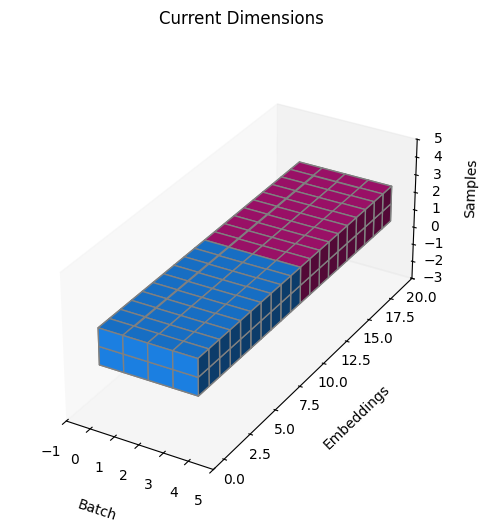

In [174]:
# hide cell
import numpy as np
import matplotlib.pyplot as plt

# Dimensions of the cube
dim1, dim2, dim3 = 4, 20, 2  # First, second, and third dimensions (x, z, y)

# Create a 3D grid for the cube
x, y, z = np.meshgrid(
    np.arange(dim1), np.arange(dim3), np.arange(dim2), indexing="ij"
)

# Initialize a boolean array for the cube
cube = np.ones((dim1, dim2, dim3), dtype=bool)

# Define colors: alternate colors along the second dimension (z-axis)
colors = np.empty(cube.shape, dtype=object)
for j in range(dim2):  # Iterate over the second dimension
    color = "#C71585" if j > 9 else "#1E90FF"
    colors[:, j, :] = color

# Plot the filled cube
fig = plt.figure(figsize=(6, 6))  # Larger figure size for better spacing
ax = fig.add_subplot(111, projection="3d")

# Use voxels to render the cube
ax.voxels(cube, facecolors=colors, edgecolor="#808080")  # Softer edge color

# Set labels
ax.set_xlabel("Batch", labelpad=10)
ax.set_ylabel("Embeddings", labelpad=25)
ax.set_zlabel("Samples", labelpad=10)

# Adjust the axis limits
ax.set_xlim(-1, dim1 + 1)    # Add breathing space for the x-axis
ax.set_ylim(-1, dim2)        # Add breathing space for the y-axis
ax.set_zlim(-3, dim3 + 3)    # Extend limits on z-axis for better spread

# Adjust aspect ratio for better proportions
ax.set_box_aspect([dim1, dim2 / 2, dim3 * 2])  # Emphasize z-dimension scaling

# Remove gridlines for clarity
ax.grid(False)

# Set background color to white for better contrast
ax.set_facecolor("white")

# Title
plt.title("Current Dimensions", pad=20)
plt.show()


### Detour: Batched Matrix Multiplication in PyTorch

We know $A_{4 \times 80} \cdot B_{80 \times 200}$ will produce an output matrix that is $C_{4 \times 200}$. In PyTorch, we can do something more:

Say the dimensions are: $A_{4 \times 4 \times 80}$ and you're multiplying it with $B_{80 \times 200}$. You have a 3D tensor and a 2D matrix. Can you multiply these? In PyTorch, you can! What ends up happening is as follows:

You treat the 1st dimension as the batch dimension. So in a way, you *slide* the matrix multiplication operation across the batch dimension and you get an output with the shape: $C_{4 \times 4 \times 200}$. Across each of the $4 \times 80$ *layers* of the cube, we're doing the matrix multiplication and getting a $4 \times 200$ *layer* for the output.


## Training WaveNet

With this setup, let's build the WaveNet architecture. We will need to modify the `Flatten` and the `BatchNorm1d` layers of the model. Rest of the layers can stay the same.

In [175]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True) -> None:
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight # Note that even if x is of higher dimensionality, PyTorch can handle it by considering them as batch dims
        if self.bias is not None:
            self.out += self.bias
        return self.out
        
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class FlattenConsecutive:
    def __init__(self, n) -> None:
        self.n = n # The number chars to fuse.

    def __call__(self, x) -> None:
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)

        # If you shape (4, 2, 10), then reshaping it is going to give you (4, 1, 20). So you can squeeze out the extra 1 dimension
        if x.shape[1] == 1:
            x = x.squeeze(1) # Now the shape will be (4, 20) which is fine and PyTorch can handle this matrix multiplication
  
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps # Small number to avoid zero division error when normalization
        self.momentum = momentum
        self.training = True

        # Parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Not parameters- "buffers"
        self.running_mean = torch.ones(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, x:torch.Tensor):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize to zero mean and unit variance

        self.out = self.gamma * xhat +  self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

Now, let's train this model! We'll use `FlattenConsecutive` instead of `Flatten`, and instead of using just one layer, we'll use multiple because we'll be creating a hierarchical model.

In [176]:
block_size = 8 # Change the context to a length of 8

def build_dataset(words):
    X, Y = [ ], [ ]

    for w in words:
        context = [0] * block_size # For start of the word, have a padded context
        for char in w + ".":
            idx = stoi[char]
            X.append(context)
            Y.append(idx)

            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [177]:
# Train, Validation, and test split
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words=words[:n1]) # 80% of data
X_val, Y_val = build_dataset(words=words[n1:n2]) # 10% of data
X_test, Y_test = build_dataset(words=words[n2:]) # 10% of data

print("Train sizes: ", X_train.shape, Y_train.shape)
print("Validation Sizes: ", X_val.shape, Y_val.shape)
print("Test Sizes: ", X_test.shape, Y_test.shape)

Train sizes:  torch.Size([182625, 8]) torch.Size([182625])
Validation Sizes:  torch.Size([22655, 8]) torch.Size([22655])
Test Sizes:  torch.Size([22866, 8]) torch.Size([22866])


In [178]:
torch.manual_seed(42);

In [179]:
n_emb = 10
n_hidden = 200

model = Sequential([
  Embedding(vocab_size, n_emb),
  FlattenConsecutive(2), Linear(n_emb * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True

print("Total Number of Parameters: ", sum(p.nelement() for p in parameters))  # number of parameters in total

Total Number of Parameters:  170897


In [180]:
epochs = 10_000
batch_size = 32
lossi = [ ]

for i in range(epochs):

    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    x_batch, y_batch = X_train[ix], Y_train[ix]

    logits = model(x_batch)
    loss = F.cross_entropy(logits, y_batch)

    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data -= 0.01 * p.grad

    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/  10000: 3.9208
   1000/  10000: 2.1128
   2000/  10000: 2.5321
   3000/  10000: 2.6973
   4000/  10000: 2.6557
   5000/  10000: 2.5512
   6000/  10000: 2.4378
   7000/  10000: 2.3415
   8000/  10000: 2.4774
   9000/  10000: 1.8434


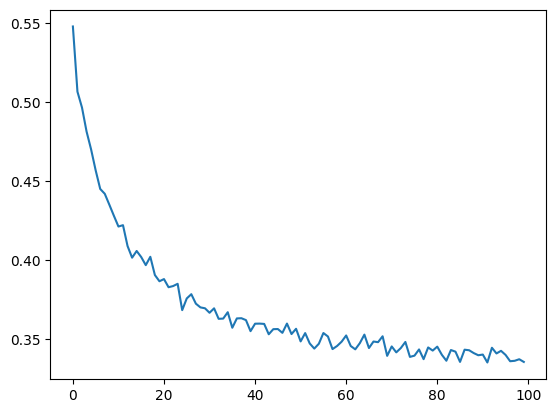

In [181]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1)) # Plot average of 100 losses

### Evaluation and Sampling

Now that we have trained a different model, let's try to evaluate the loss and let's try to sample from it.

In [182]:
# Set "evaluation" mode for each layer
for layer in model.layers:
    layer.training = False

In [183]:
split_loss('train')
split_loss('val')

For train, loss was: 2.169342279434204
For val, loss was: 2.181504487991333


We have a slight improvement on the older model. In Andrej's tutorial, he actually didn't get much improvement on the model. But still, not bad!

In [184]:
for _ in range(20):
    out = [ ]
    context = [ 0 ] * block_size

    while True:
        logits = model(torch.tensor([context]))
        probabilities = F.softmax(logits, dim=1)

        ix = torch.multinomial(probabilities, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

rendie.
quwillyan.
cyngerelyn.
reylan.
zaygrin.
moveen.
nylie.
chais.
jaksen.
kasnaly.
caarian.
ahajelli.
toxstton.
makwi.
ayonne.
cahky.
jark.
maylin.
rosler.
abdh.


And we have some decent names also- "jark", "rosler", "jaksen", "nylie". Not bad at all!